In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import timedelta
import seaborn as sns
import glob


def find_unique_file(pattern: str) -> str:
    """
    Finds a unique file in the current directory matching the given pattern.
    Throws an error if no file or multiple files match the pattern.
    
    Args:
    - pattern (str): The pattern to search for.
    
    Returns:
    - str: The name of the file if exactly one match is found.
    
    Raises:
    - FileNotFoundError: If no files match the pattern.
    - FileExistsError: If multiple files match the pattern.
    """
    files = glob.glob(pattern)
    
    if len(files) == 0:
        raise FileNotFoundError("No files matching the pattern were found.")
    elif len(files) > 1:
        raise FileExistsError("Multiple files matching the pattern exist.")
    else:
        return files[0]

In [18]:
reuse = pd.read_csv(find_unique_file("*.reuse.stage2.csv"),
  names=["File", "Condition", "Metric", "Value"])
noreuse = pd.read_csv(find_unique_file("*.noreuse.stage2.csv"), 
                      names=["File", "Condition", "Metric", "Value"])
print("noreuse"); display(noreuse);
print("reuse"); display(reuse);

noreuse


,File,Condition,Metric,Value
0,Init/Prelude.lean,reuse_across_ctor_disabled,rss,131383296
1,Init/Prelude.lean,reuse_across_ctor_disabled,time_elapsed_ms,1586
2,Lean/Runtime.lean,reuse_across_ctor_disabled,rss,46759936
3,Lean/Runtime.lean,reuse_across_ctor_disabled,time_elapsed_ms,40
4,Init/Coe.lean,reuse_across_ctor_disabled,rss,53329920
...,...,...,...,...
1695,Lake/CLI/Main.lean,reuse_across_ctor_disabled,time_elapsed_ms,3413
1696,Lake/CLI.lean,reuse_across_ctor_disabled,rss,242434048
1697,Lake/CLI.lean,reuse_across_ctor_disabled,time_elapsed_ms,197
1698,Lake/Main.lean,reuse_across_ctor_disabled,rss,254935040


reuse


,File,Condition,Metric,Value


In [19]:
# Filtering the rows where Metric is 'time_elapsed_ms' and then summing the 'Value' column for both DataFrames
sum_time_elapsed_reuse = reuse[reuse["Metric"] == "time_elapsed_ms"]["Value"].sum()
sum_time_elapsed_no_reuse = noreuse[noreuse["Metric"] == "time_elapsed_ms"]["Value"].sum()

sum_time_elapsed_reuse, sum_time_elapsed_no_reuse

# Ensuring the values are in a compatible format for timedelta
time_reuse = timedelta(milliseconds=int(sum_time_elapsed_reuse))
time_no_reuse = timedelta(milliseconds=int(sum_time_elapsed_no_reuse))

# Formatting as hours:minutes:seconds.milliseconds again
time_format_reuse = str(time_reuse)
time_format_no_reuse = str(time_no_reuse)
print(f"time (reuse): {time_format_reuse} | time (noreuse): {time_format_no_reuse}")

time (reuse): 0:00:00 | time (noreuse): 0:49:36.793000


In [20]:
df_merged = pd.merge(reuse, noreuse, on=["File", "Metric"], suffixes=('_reuse', '_no_reuse'))
display(df_merged)

,File,Condition_reuse,Metric,Value_reuse,Condition_no_reuse,Value_no_reuse


,File,Value_reuse,Value_no_reuse,absolute_diff,%Decrease


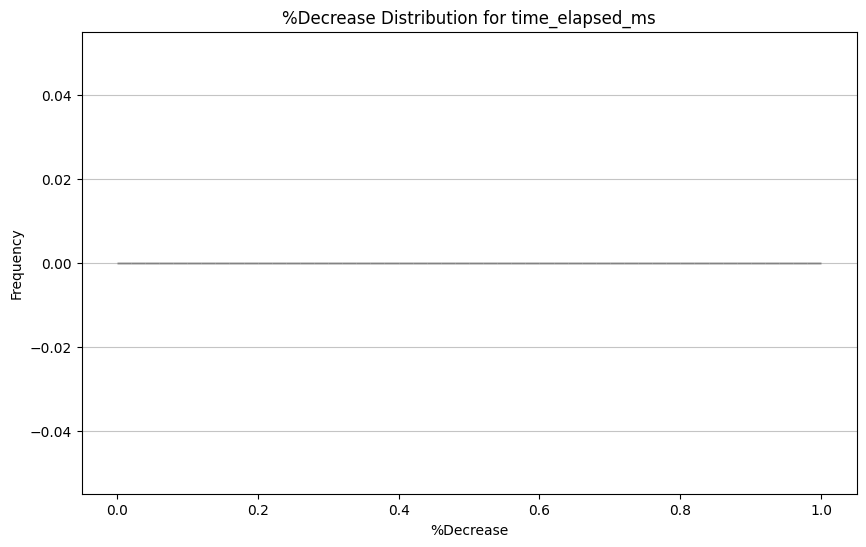

,File,Value_reuse,Value_no_reuse,absolute_diff,%Decrease


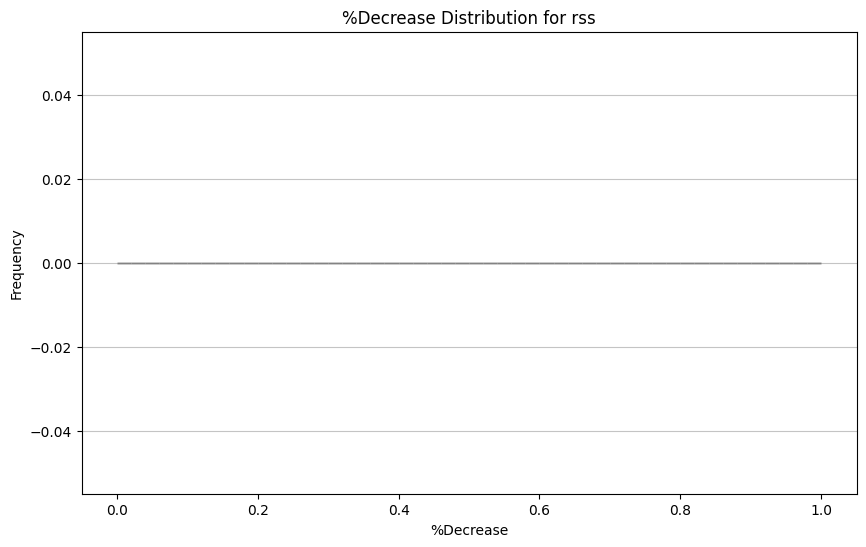

,File,Value_reuse,Value_no_reuse,absolute_diff,%Decrease


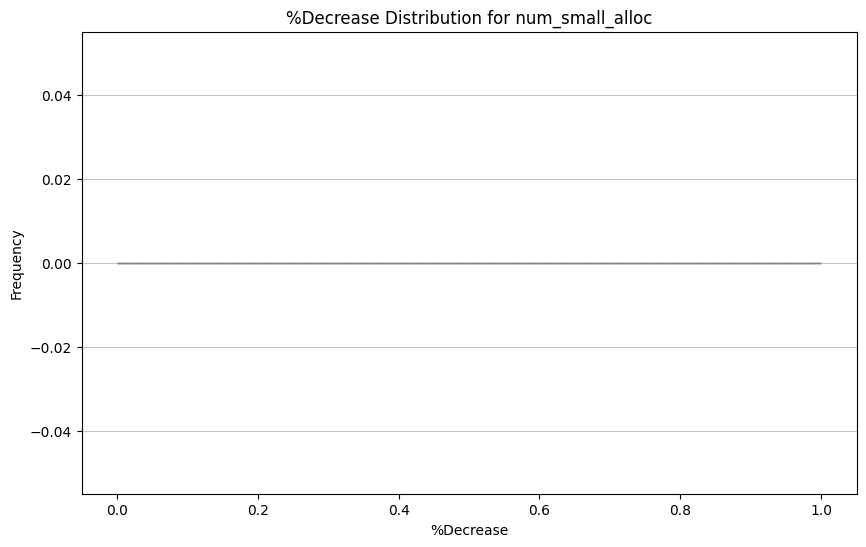

,File,Value_reuse,Value_no_reuse,absolute_diff,%Decrease


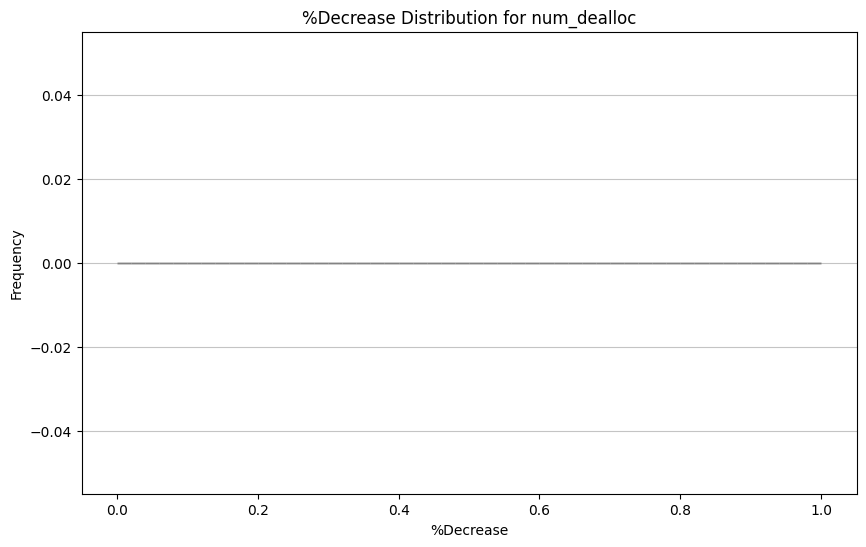

,File,Value_reuse,Value_no_reuse,absolute_diff,%Decrease


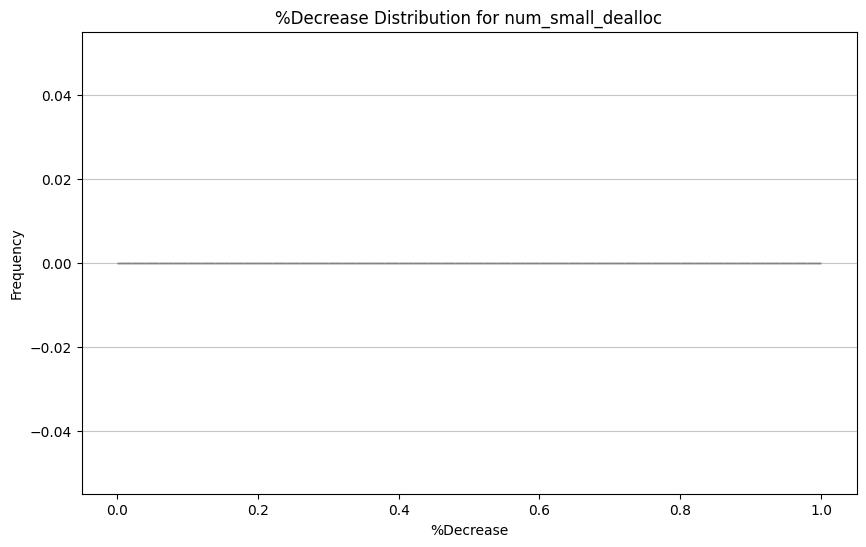

/Users/sid/venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sid/venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<Axes: >

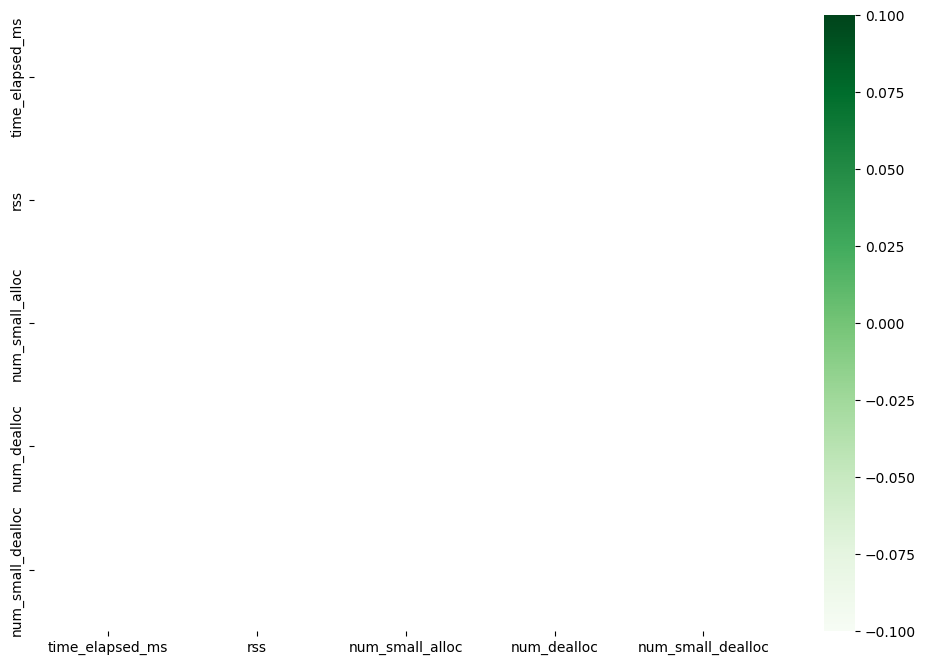

In [21]:
# metrics for which we should compute decreases
df_corr = pd.DataFrame(df_merged["File"].unique(), columns=["File"]) 

for metric in ["time_elapsed_ms", "rss", "num_small_alloc", "num_dealloc", "num_small_dealloc"]:
  display(HTML(f"<h1>{metric}</h1>"))
  df_metric = df_merged[df_merged["Metric"] == metric].copy()
  df_metric["absolute_diff"] = df_merged["Value_no_reuse"] - df_merged["Value_reuse"]
  df_metric["%Decrease"] = (
    100.0 * (df_merged["Value_no_reuse"] - df_merged["Value_reuse"]) / df_merged["Value_no_reuse"]
  )
  df_metric = df_metric.drop(["Condition_reuse", "Condition_no_reuse", "Metric"], axis=1)

  df_kv = df_metric[["File", "%Decrease"]].copy()
  df_kv.rename(columns={"%Decrease": metric}, inplace=True)
  df_corr = pd.merge(df_corr, df_kv, on="File", how="outer")
  
  # Sorting by maximum decrease
  df_metric_sorted = df_metric.sort_values(by="%Decrease", ascending=False)
  df_metric_sorted.reset_index(drop=True, inplace=True) # changes index to start from zero.
  display(df_metric_sorted)
  plt.figure(figsize=(10, 6))
  plt.hist(df_metric_sorted['%Decrease'], bins=50, color='skyblue', edgecolor='black')
  plt.title(f'%Decrease Distribution for {metric}')
  plt.xlabel('%Decrease')
  plt.ylabel('Frequency')
  plt.grid(axis='y', alpha=0.75)
  plt.show()

corr = df_corr.drop('File', axis=1).corr()  # Assuming df_corr is defined and populated
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens",annot=True)


,time_elapsed_ms,num_alloc
File,,


/Users/sid/venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sid/venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


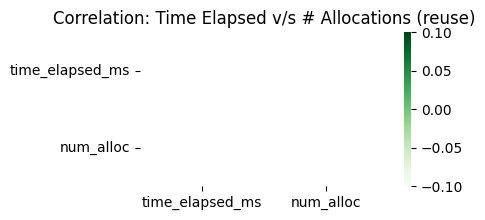

,time_elapsed_ms,num_alloc
File,,
Lean/Elab/Tactic/Omega/Frontend.lean,56431,NaN
Lean/Elab/Do.lean,54346,NaN
Lean/Elab/App.lean,44970,NaN
Lean/Elab/Quotation.lean,44062,NaN
Lean/PrettyPrinter/Delaborator/Builtins.lean,38815,NaN
...,...,...
Init/Data/ByteArray.lean,82,NaN
Init/Data/Char.lean,79,NaN
Init/System/Platform.lean,76,NaN


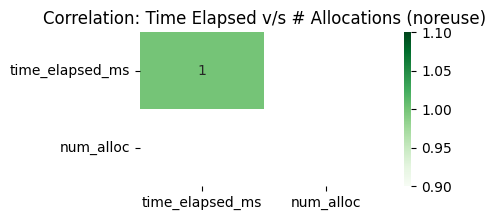

,time_elapsed_ms,num_alloc
File,,
Lean/Elab/Tactic/Omega/Frontend.lean,56431,NaN
Lean/Elab/Do.lean,54346,NaN
Lean/Elab/App.lean,44970,NaN
Lean/Elab/Quotation.lean,44062,NaN
Lean/PrettyPrinter/Delaborator/Builtins.lean,38815,NaN
...,...,...
Init/Data/ByteArray.lean,82,NaN
Init/Data/Char.lean,79,NaN
Init/System/Platform.lean,76,NaN


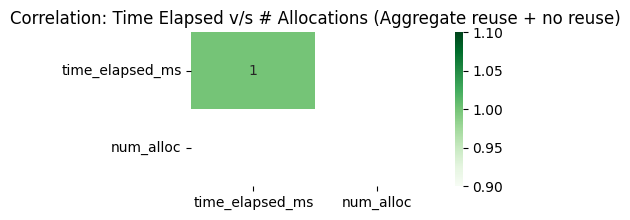

In [22]:
df_full = None

# for each file, grab num alloc and time elapsed.
variant2df = { "reuse" : reuse, "noreuse": noreuse }
for (variant, df) in variant2df.items():
    metric2df = {}
    for metric in ["time_elapsed_ms", "num_alloc"]:
      out = df[df["Metric"] == metric].copy()
      out = out[["File", "Value"]]
      out.rename(columns={"Value" : metric}, inplace=True)
      out = out[["File", metric]].set_index("File")
      metric2df[metric] = out
    
    df_metrics_merged = metric2df["time_elapsed_ms"].join(metric2df["num_alloc"])
    df_metrics_merged = df_metrics_merged.sort_values(by='time_elapsed_ms', ascending=False)

    display(HTML(f"<h3>Correlation: Time elapsed v/s # allocations ({variant})</h3>"))
    display(df_metrics_merged)
    corr = df_metrics_merged.corr()  # Assuming df_corr is defined and populated
    plt.figure(figsize=(4,2))
    sns.heatmap(corr, cmap="Greens",annot=True)
    plt.title(f"Correlation: Time Elapsed v/s # Allocations ({variant})")
    plt.show()

    
    if df_full is None:
        df_full = df_metrics_merged
    else:
        df_full = pd.concat([df_full, df_metrics_merged])

df_full = df_full.sort_values(by='time_elapsed_ms', ascending=False)
display(df_full)
corr = df_full.corr() 
plt.figure(figsize=(4,2))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.title('Correlation: Time Elapsed v/s # Allocations (Aggregate reuse + no reuse)')
plt.show()
